In [27]:
# --- 1. Import Libraries ---
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
import albumentations as A
import json
import os
import git
from sklearn.model_selection import train_test_split
from flask import Flask, request, jsonify
import requests
import matplotlib.pyplot as plt
from tensorflow.keras.utils import Sequence

## Load Dataset

In [28]:
# Clone repository
repo_url = "https://github.com/Ezraliano/Dataset_NeoDental.git"
local_dir = "Dataset_NeoDental"
if not os.path.exists(local_dir):
    git.Repo.clone_from(repo_url, local_dir)

In [29]:
# Define DEST_DIR
DEST_DIR = "Dataset_NeoDental"

# Create folder structure of destination dataset
os.makedirs(os.path.join(DEST_DIR, "train", "images"), exist_ok=True)
os.makedirs(os.path.join(DEST_DIR, "train", "labels"), exist_ok=True)
os.makedirs(os.path.join(DEST_DIR, "val", "images"), exist_ok=True)
os.makedirs(os.path.join(DEST_DIR, "val", "labels"), exist_ok=True)
os.makedirs(os.path.join(DEST_DIR, "test", "images"), exist_ok=True)
os.makedirs(os.path.join(DEST_DIR, "test", "labels"), exist_ok=True)

In [30]:
# Load metadata dan mapping kelas
SRC_DIR = "Dataset_NeoDental"
meta = json.load(open(os.path.join(SRC_DIR, "meta.json")))
classes = {entry["title"]: index for index, entry in enumerate(meta["classes"])}

In [31]:
def polygon_to_mask(annotation, image_shape, class_map):
    mask = np.zeros(image_shape[:2], dtype=np.uint8)
    for obj in annotation['objects']:
        class_title = obj['classTitle']
        if class_title not in class_map:
            print(f"Kelas '{class_title}' tidak ditemukan dalam mapping. Objek diabaikan.")
            continue  # Skip kelas yang tidak valid

        # Pastikan struktur points valid
        if 'points' not in obj or 'exterior' not in obj['points'] or len(obj['points']['exterior']) < 1:
            print(f"Objek {obj['id']} tidak memiliki polygon valid. Objek diabaikan.")
            continue

        # Ambil titik exterior dan pastikan bertipe integer
        try:
            polygon = np.array(obj['points']['exterior'], dtype=np.int32)
        except:
            print(f"Koordinat polygon pada objek {obj['id']} tidak valid. Objek diabaikan.")
            continue

        # Pastikan jumlah titik cukup untuk poligon (min 3 titik)
        if len(polygon) < 3:
            print(f"Poligon pada objek {obj['id']} tidak valid (kurang dari 3 titik). Objek diabaikan.")
            continue

        # Gambar poligon ke mask
        cv2.fillPoly(mask, [polygon], color=class_map[class_title])

    return mask

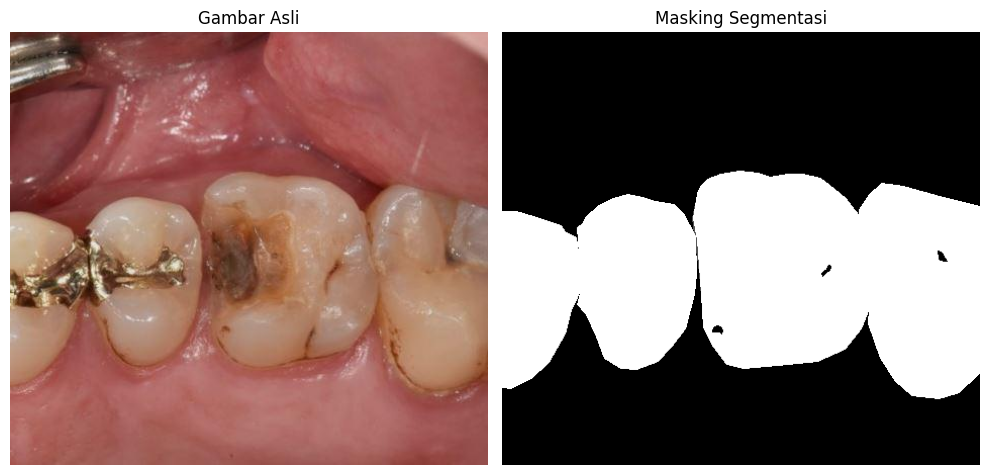

In [32]:
# Cari file gambar dan anotasi yang cocok
img_dir = os.path.join(SRC_DIR, "train", "img")
ann_dir = os.path.join(SRC_DIR, "train", "ann")

# Ambil salah satu file sebagai contoh
img_files = [f for f in os.listdir(img_dir) if f.endswith('.jpg')]
if not img_files:
    raise Exception("Tidak ada file gambar ditemukan!")

img_filename = img_files[0]
img_path = os.path.join(img_dir, img_filename)
ann_path = os.path.join(ann_dir, img_filename + ".json")

# Pastikan file JSON ada
if not os.path.exists(ann_path):
    raise FileNotFoundError(f"File anotasi tidak ditemukan: {ann_path}")

# Load gambar dan anotasi
image = cv2.imread(img_path)
with open(ann_path, 'r') as f:
    annotation = json.load(f)

# Buat mask
mask = polygon_to_mask(annotation, image.shape, classes)

# Tampilkan hasil
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Gambar Asli")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title("Masking Segmentasi")
plt.axis("off")
plt.tight_layout()
plt.show()

## Explorasi Data Analysis

In [33]:
img_dir = os.path.join(SRC_DIR, "train", "img")
ann_dir = os.path.join(SRC_DIR, "train", "ann")

img_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.jpg')])
ann_files = sorted([f for f in os.listdir(ann_dir) if f.endswith('.json')])

print(f"Jumlah gambar: {len(img_files)}")
print(f"Jumlah anotasi: {len(ann_files)}")

missing_anns = [f for f in img_files if f + ".json" not in ann_files]
print(f"Gambar tanpa anotasi: {len(missing_anns)}")


Jumlah gambar: 1991
Jumlah anotasi: 1991
Gambar tanpa anotasi: 0


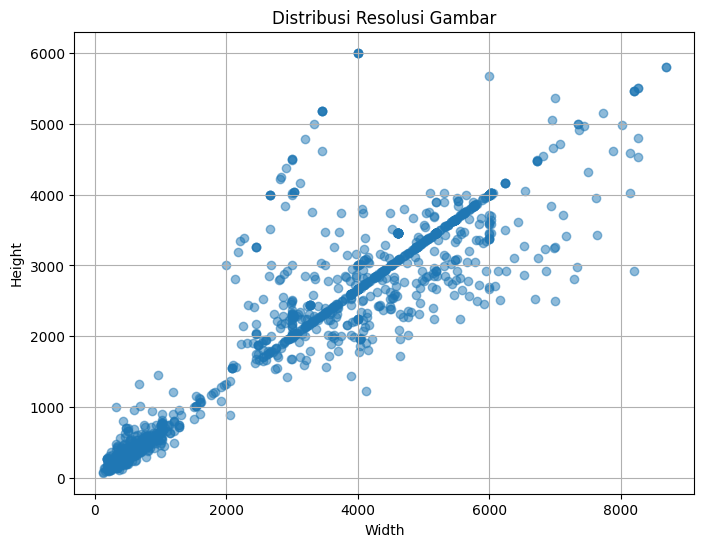

In [34]:
sizes = []
for file in img_files:
    path = os.path.join(img_dir, file)
    img = cv2.imread(path)
    if img is not None:
        h, w = img.shape[:2]
        sizes.append((w, h))

sizes_arr = np.array(sizes)
plt.figure(figsize=(8, 6))
plt.scatter(sizes_arr[:, 0], sizes_arr[:, 1], alpha=0.5)
plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Distribusi Resolusi Gambar")
plt.grid(True)
plt.show()


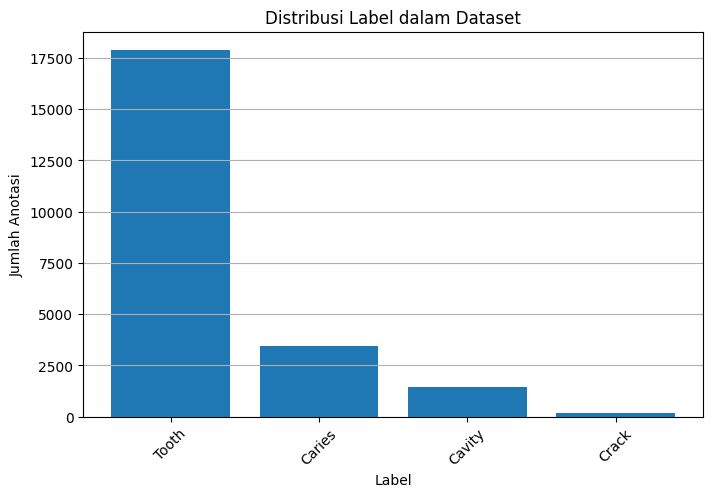

Distribusi kelas:
Tooth: 17884 objek
Caries: 3451 objek
Cavity: 1452 objek
Crack: 150 objek


In [35]:
from collections import Counter

label_counts = Counter()

for ann_file in ann_files:
    path = os.path.join(ann_dir, ann_file)
    with open(path, 'r') as f:
        data = json.load(f)
        for obj in data["objects"]:
            label_counts[obj["classTitle"]] += 1

# Visualisasi
plt.figure(figsize=(8, 5))
plt.bar(label_counts.keys(), label_counts.values())
plt.title("Distribusi Label dalam Dataset")
plt.ylabel("Jumlah Anotasi")
plt.xlabel("Label")
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.show()

print("Distribusi kelas:")
for label, count in label_counts.items():
    print(f"{label}: {count} objek")


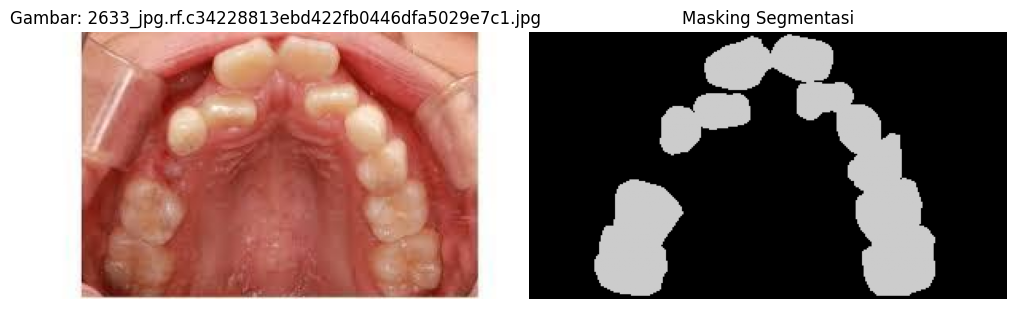

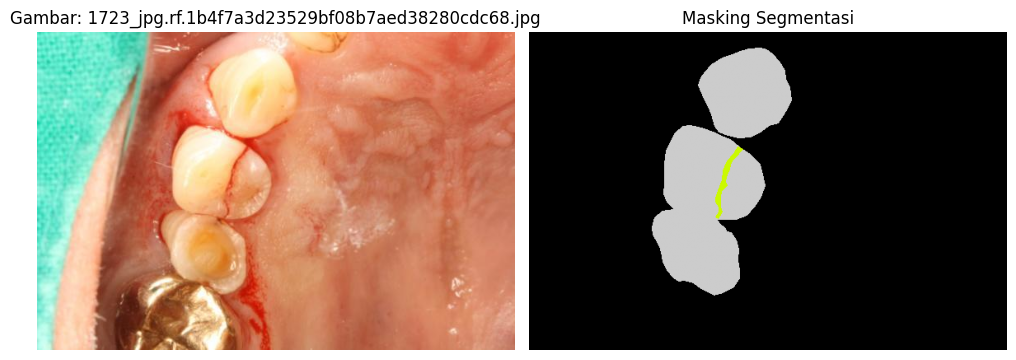

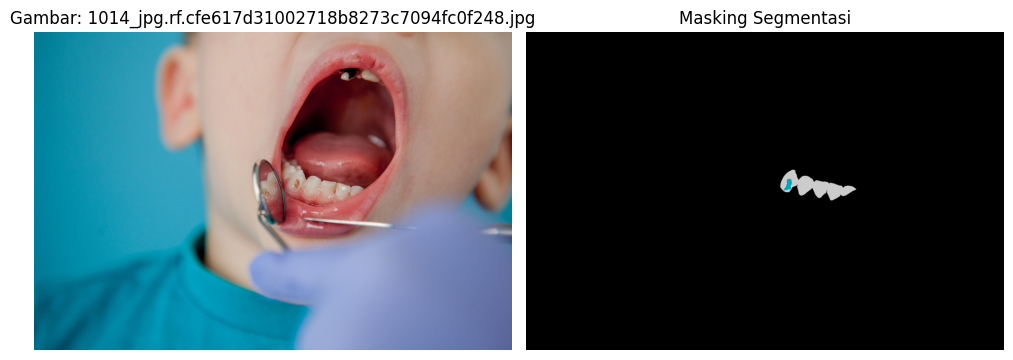

In [36]:
import random

n_samples = 3
sample_imgs = random.sample(img_files, n_samples)

for img_file in sample_imgs:
    img_path = os.path.join(img_dir, img_file)
    ann_path = os.path.join(ann_dir, img_file + ".json")

    image = cv2.imread(img_path)
    with open(ann_path, 'r') as f:
        annotation = json.load(f)

    mask = polygon_to_mask(annotation, image.shape, classes)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"Gambar: {img_file}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='nipy_spectral')
    plt.title("Masking Segmentasi")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


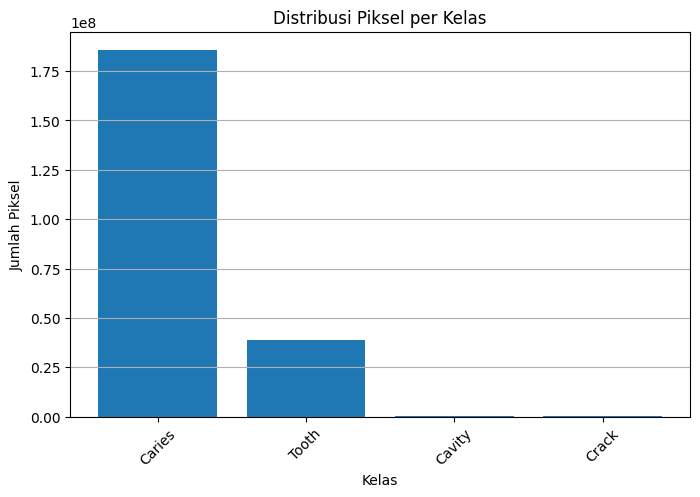

In [37]:
pixel_distribution = Counter()

for img_file in img_files[:20]:  # Gunakan subset jika data besar
    img_path = os.path.join(img_dir, img_file)
    ann_path = os.path.join(ann_dir, img_file + ".json")

    if os.path.exists(ann_path):
        image = cv2.imread(img_path)
        with open(ann_path, 'r') as f:
            annotation = json.load(f)
        mask = polygon_to_mask(annotation, image.shape, classes)

        for cls_id in np.unique(mask):
            pixel_distribution[cls_id] += np.sum(mask == cls_id)

# Tampilkan hasil
label_map_inv = {v: k for k, v in classes.items()}
labels = [label_map_inv[c] for c in pixel_distribution.keys()]
pixels = pixel_distribution.values()

plt.figure(figsize=(8, 5))
plt.bar(labels, pixels)
plt.title("Distribusi Piksel per Kelas")
plt.ylabel("Jumlah Piksel")
plt.xlabel("Kelas")
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.show()


## Data Prepocessing

In [38]:
IMG_SIZE = 256  # Ukuran yang akan digunakan untuk U-Net

def preprocess_image(img_path):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image.astype("float32") / 255.0  # Normalisasi
    return image

def preprocess_mask(mask_path, class_map):
    with open(mask_path, 'r') as f:
        annotation = json.load(f)

    # Dapatkan nama file tanpa .json
    base_filename = os.path.splitext(os.path.basename(mask_path))[0]  # e.g. '2462_jpg.rf.xxx.jpg'
    image_path = os.path.join(os.path.dirname(mask_path).replace("ann", "img"), base_filename)

    if not os.path.exists(image_path):
        print(f"Warning: Image file not found: {image_path}")
        return None

    original_image = cv2.imread(image_path)
    original_shape = original_image.shape

    mask = polygon_to_mask(annotation, original_shape, class_map)
    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
    mask = (mask > 0).astype("float32")  # Binarisasi


    return mask

In [39]:
from sklearn.model_selection import train_test_split

# Buat list file
img_files = sorted([f for f in os.listdir(img_dir) if f.endswith(".jpg")])
ann_files = [f + ".json" for f in img_files if os.path.exists(os.path.join(ann_dir, f + ".json"))]

# Pastikan hanya pasangan yang valid
img_paths = [os.path.join(img_dir, f) for f in img_files if f + ".json" in ann_files]
mask_paths = [os.path.join(ann_dir, f + ".json") for f in img_files if f + ".json" in ann_files]

# Split
train_imgs, val_imgs, train_masks, val_masks = train_test_split(img_paths, mask_paths, test_size=0.2, random_state=42)

print(f"Train: {len(train_imgs)}, Val: {len(val_imgs)}")


Train: 1592, Val: 399


In [40]:
from tensorflow.keras.utils import Sequence

class DentalDataset(Sequence):
    def __init__(self, image_paths, mask_paths, class_map, batch_size=8, augment=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.class_map = class_map
        self.batch_size = batch_size
        self.augment = augment

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, idx):
        batch_x = self.image_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.mask_paths[idx * self.batch_size:(idx + 1) * self.batch_size]

        images, masks = [], []

        for img_path, mask_path in zip(batch_x, batch_y):
            img = preprocess_image(img_path)
            mask = preprocess_mask(mask_path, self.class_map)

            # Skip if mask is None
            if mask is None:
                print(f"Skipping {img_path} due to missing mask.")
                continue

            # Expand dim untuk masks (channel = 1)
            mask = np.expand_dims(mask, axis=-1)

            # Optional augmentasi
            if self.augment:
                augmented = self.augment(image=img, mask=mask)
                img = augmented["image"]
                mask = augmented["mask"]

            images.append(img)
            masks.append(mask)

        # Check if any images were processed
        if not images:
            print(f"Warning: Batch {idx} contains no valid image-mask pairs.")
            return np.array([]), np.array([])  # Return empty arrays if no images are found

        return np.array(images), np.array(masks)


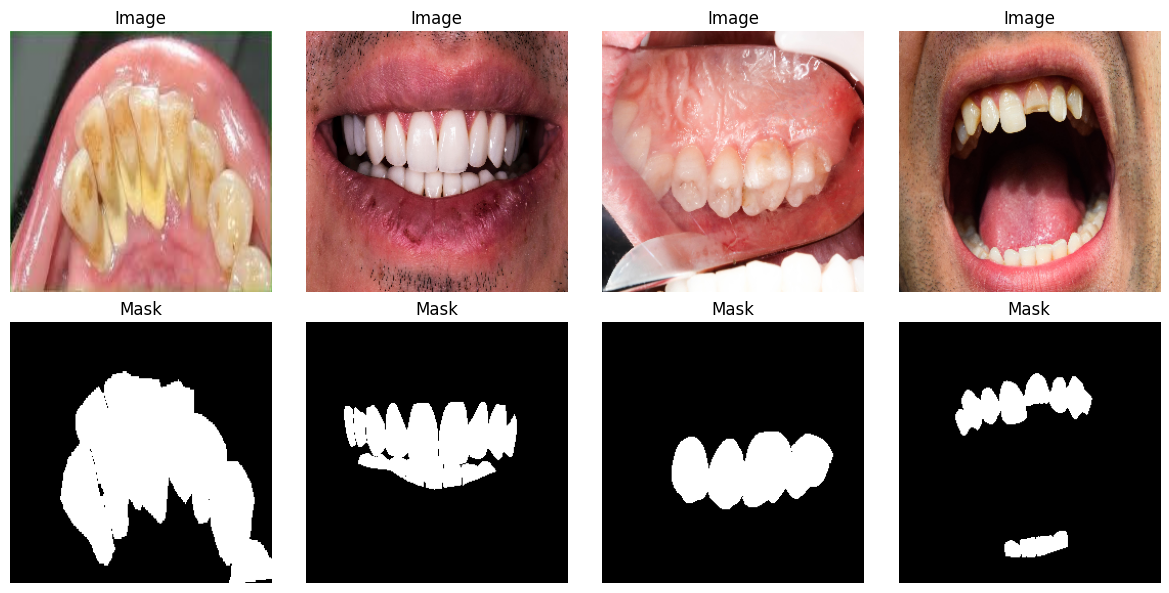

In [41]:
train_dataset = DentalDataset(train_imgs, train_masks, classes, batch_size=4)
val_dataset = DentalDataset(val_imgs, val_masks, classes, batch_size=4)

# Ambil satu batch untuk cek
sample_imgs, sample_masks = train_dataset[0]

plt.figure(figsize=(12, 6))
for i in range(4):
    plt.subplot(2, 4, i + 1)
    plt.imshow(sample_imgs[i])
    plt.axis("off")
    plt.title("Image")
    plt.subplot(2, 4, i + 5)
    plt.imshow(sample_masks[i].squeeze(), cmap='gray')
    plt.axis("off")
    plt.title("Mask")
plt.tight_layout()
plt.show()


## Modeling

In [42]:
from tensorflow.keras import layers, Model

def unet_model(input_size=(256, 256, 3), num_classes=1):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D(pool_size=(2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1], axis=3)
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model


In [43]:
model = unet_model(input_size=(256, 256, 3), num_classes=1)

model.compile(optimizer='adam',
              loss='binary_crossentropy',  # cocok untuk binary mask
              metrics=['accuracy'])

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 256, 256,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 256, 256,  │     36,928 │ conv2d_19[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 128, 128,  │    147,584 │ conv2d_21[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 64, 64,    │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 64, 64,    │    590,080 │ conv2d_23[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 32, 32,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_6[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 32, 32,    │  2,359,808 │ conv2d_25[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 16, 16,    │          0 │ conv2d_26[0][0]   │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_7[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 16, 16,    │  9,438,208 │ conv2d_27[0][0]   │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 32, 32,    │  2,097,664 │ conv2d_28[0][0]   │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 32, 32,    │          0 │ conv2d_transpose

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_cb = ModelCheckpoint("unet_best_model.h5", save_best_only=True, monitor='val_loss', mode='min')
earlystop_cb = EarlyStopping(patience=10, restore_best_weights=True)


In [45]:
EPOCHS = 40
BATCH_SIZE = 8

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=[checkpoint_cb, earlystop_cb]
)


Epoch 1/40


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_32']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


398/398 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.7341 - loss: 0.5114

398/398 ━━━━━━━━━━━━━━━━━━━━ 200s 477ms/step - accuracy: 0.7342 - loss: 0.5113 - val_accuracy: 0.8232 - val_loss: 0.3981
Epoch 2/40
398/398 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.7942 - loss: 0.4020

398/398 ━━━━━━━━━━━━━━━━━━━━ 180s 452ms/step - accuracy: 0.7942 - loss: 0.4020 - val_accuracy: 0.8067 - val_loss: 0.3763
Epoch 3/40
398/398 ━━━━━━━━━━━━━━━━━━━━ 189s 420ms/step - accuracy: 0.8124 - loss: 0.3828 - val_accuracy: 0.7262 - val_loss: 0.4846
Epoch 4/40
398/398 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.8072 - loss: 0.3831

398/398 ━━━━━━━━━━━━━━━━━━━━ 210s 440ms/step - accuracy: 0.8072 - loss: 0.3831 - val_accuracy: 0.8264 - val_loss: 0.3657
Epoch 5/40
398/398 ━━━━━━━━━━━━━━━━━━━━ 170s 428ms/step - accuracy: 0.8219 - loss: 0.3712 - val_accuracy: 0.7863 - val_loss: 0.4088
Epoch 6/40
398/398 ━━━━━━━━━━━━━━━━━━━━ 174s 438ms/step - accuracy: 0.8115 - loss: 0.3776 - val_accuracy: 0.8176 - val_loss: 0.3743
Epoch 7/40
398/398 ━━━━━━━━━━━━━━━━━━━━ 170s 427ms/step - accuracy: 0.8102 - loss: 0.3771 - val_accuracy: 0.8130 - val_loss: 0.3800
Epoch 8/40
398/398 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.8245 - loss: 0.3592

398/398 ━━━━━━━━━━━━━━━━━━━━ 185s 464ms/step - accuracy: 0.8245 - loss: 0.3592 - val_accuracy: 0.8421 - val_loss: 0.3423
Epoch 9/40
398/398 ━━━━━━━━━━━━━━━━━━━━ 173s 434ms/step - accuracy: 0.8245 - loss: 0.3634 - val_accuracy: 0.8274 - val_loss: 0.3535
Epoch 10/40
398/398 ━━━━━━━━━━━━━━━━━━━━ 165s 414ms/step - accuracy: 0.8265 - loss: 0.3596 - val_accuracy: 0.8444 - val_loss: 0.3429
Epoch 11/40
398/398 ━━━━━━━━━━━━━━━━━━━━ 213s 442ms/step - accuracy: 0.7272 - loss: 5.3642 - val_accuracy: 0.7298 - val_loss: 0.6150
Epoch 12/40
398/398 ━━━━━━━━━━━━━━━━━━━━ 171s 431ms/step - accuracy: 0.7308 - loss: 0.5396 - val_accuracy: 0.7299 - val_loss: 0.4718
Epoch 13/40
398/398 ━━━━━━━━━━━━━━━━━━━━ 175s 439ms/step - accuracy: 0.7343 - loss: 0.4622 - val_accuracy: 0.7299 - val_loss: 0.4087
Epoch 14/40
398/398 ━━━━━━━━━━━━━━━━━━━━ 174s 436ms/step - accuracy: 0.7327 - loss: 0.4273 - val_accuracy: 0.7299 - val_loss: 0.4021
Epoch 15/40
398/398 ━━━━━━━━━━━━━━━━━━━━ 171s 429ms/step - accuracy: 0.7514 - loss

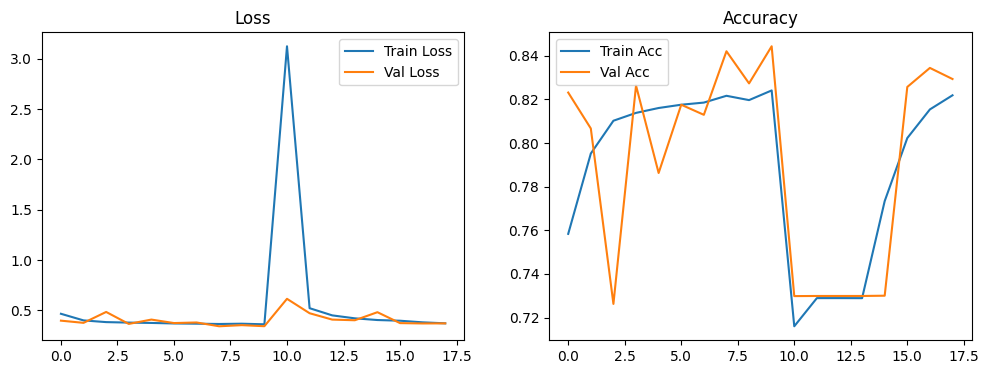

In [46]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()
plt.show()


## Evaluation

In [47]:
import tensorflow.keras.backend as K

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(K.cast(y_true, 'float32'))
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

In [48]:
val_dice = model.evaluate(val_dataset)
print(f"\nVal Loss: {val_dice[0]:.4f}")
print(f"Val Dice Coefficient: {val_dice[1]:.4f}")


100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 308ms/step - accuracy: 0.8337 - loss: 0.3499

Val Loss: 0.3423
Val Dice Coefficient: 0.8421


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_32']
Received: inputs=Tensor(shape=(1, 256, 256, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step


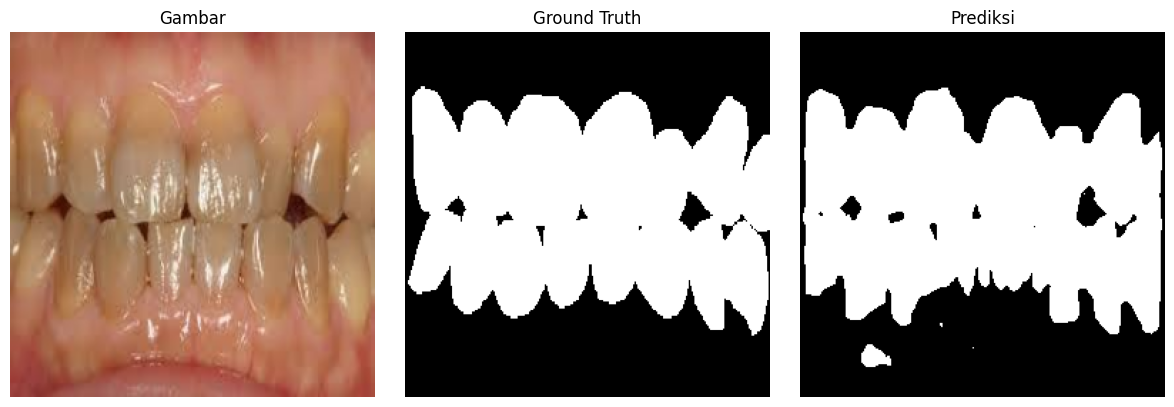

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


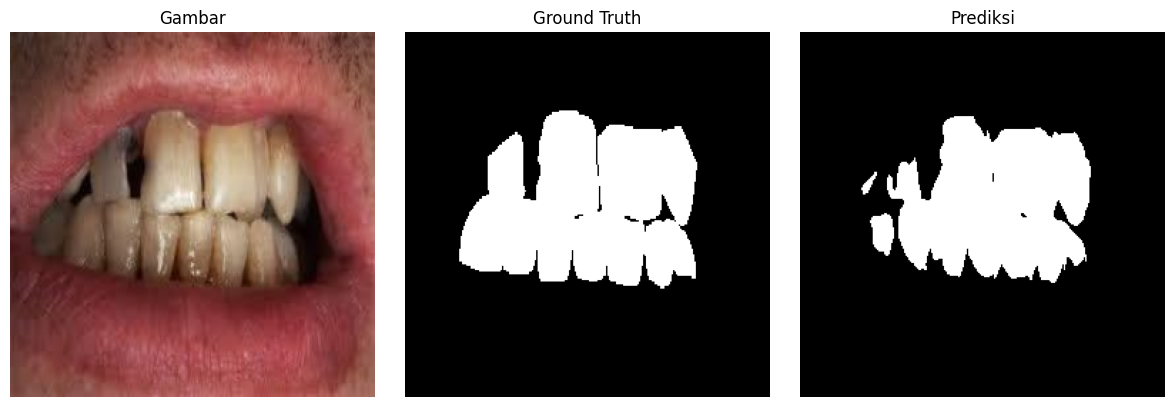

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


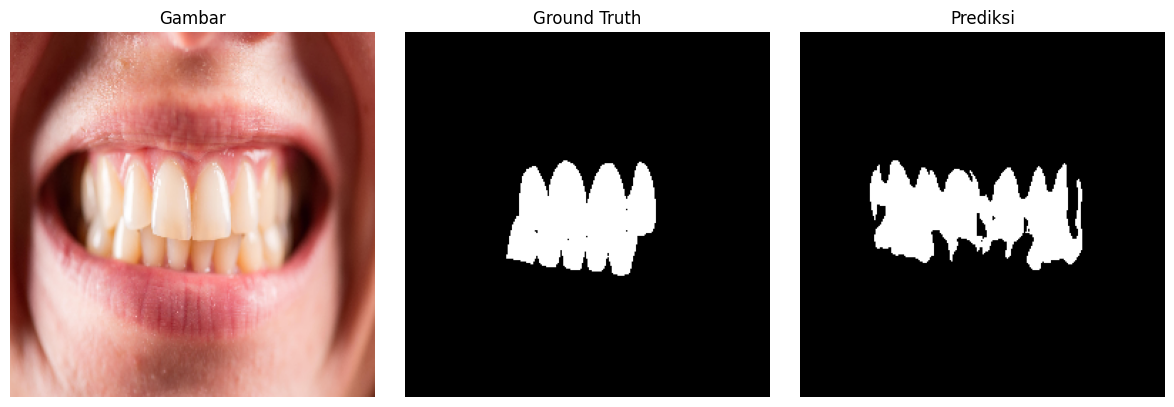

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


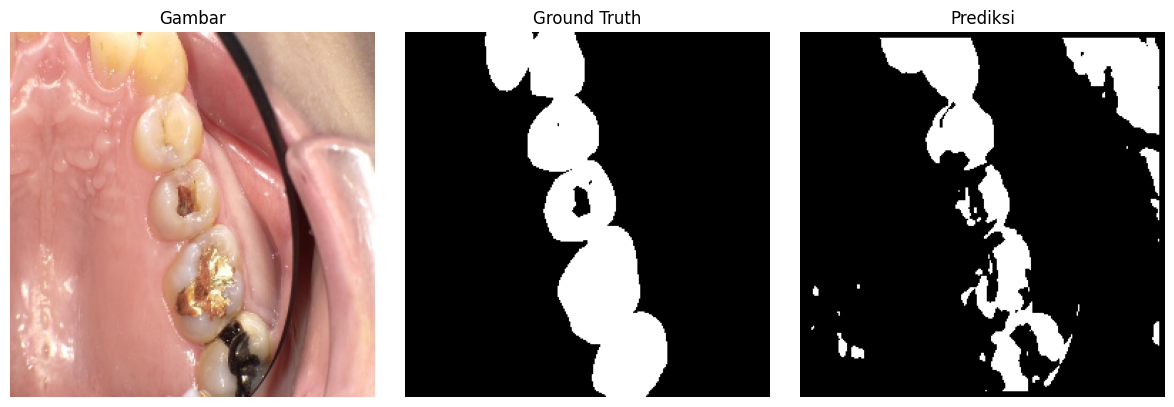

In [49]:
# Ambil sample dari val_dataset (PyTorch)
X_val_tensor, Y_val_tensor = val_dataset[0]  # satu sample

# Ubah ke numpy (Tidak perlu permute, karena sudah numpy array)
X_val = X_val_tensor  # (H, W, C)
Y_val = Y_val_tensor.squeeze() # (H, W) atau tetap (H, W)

# Loop melalui setiap gambar dalam batch
for i in range(X_val.shape[0]):
    # Tambahkan batch dimensi untuk setiap gambar
    X_val_input = X_val[i][np.newaxis, ...]  # (1, H, W, C)

    # Prediksi pakai TensorFlow model
    Y_pred = model.predict(X_val_input)[0]  # (H, W, 1)
    Y_pred_bin = (Y_pred > 0.5).astype(np.uint8).squeeze()

    # Visualisasi untuk setiap gambar
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(X_val[i])
    plt.title("Gambar")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(Y_val[i], cmap='gray')
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(Y_pred_bin, cmap='gray')
    plt.title("Prediksi")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 791ms/step


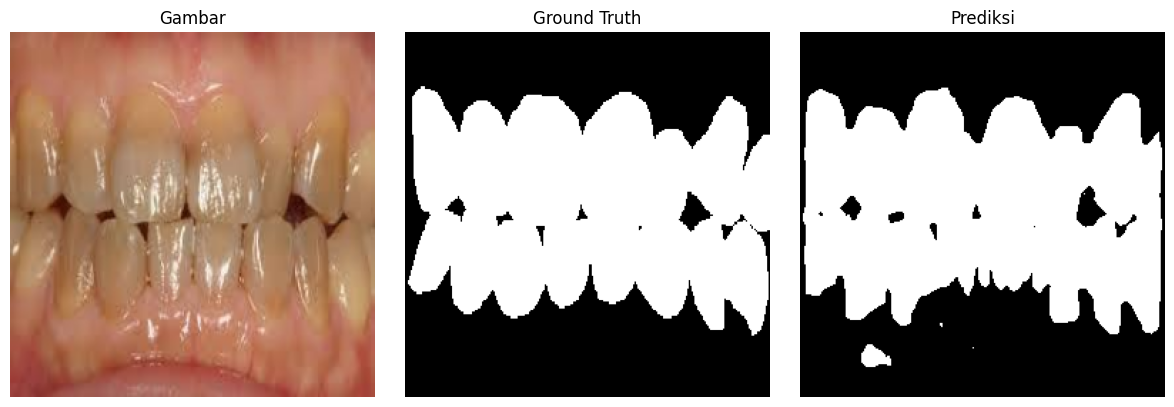

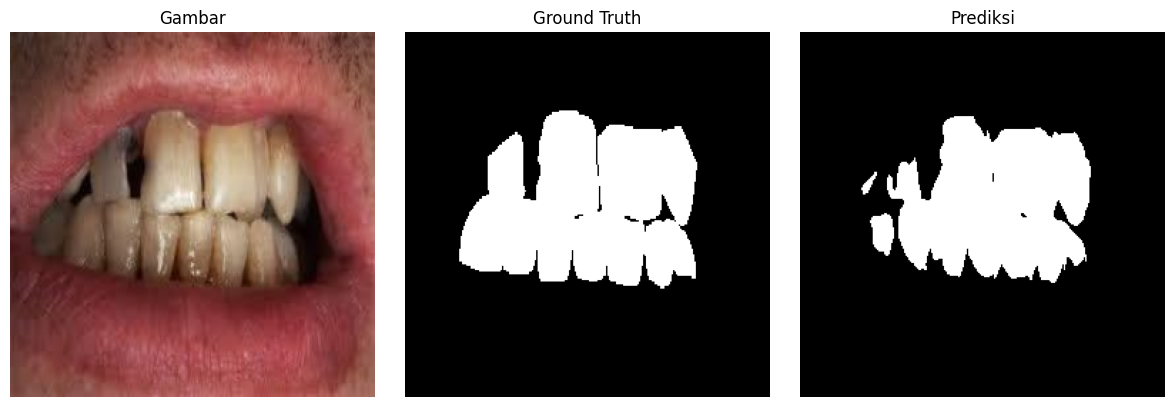

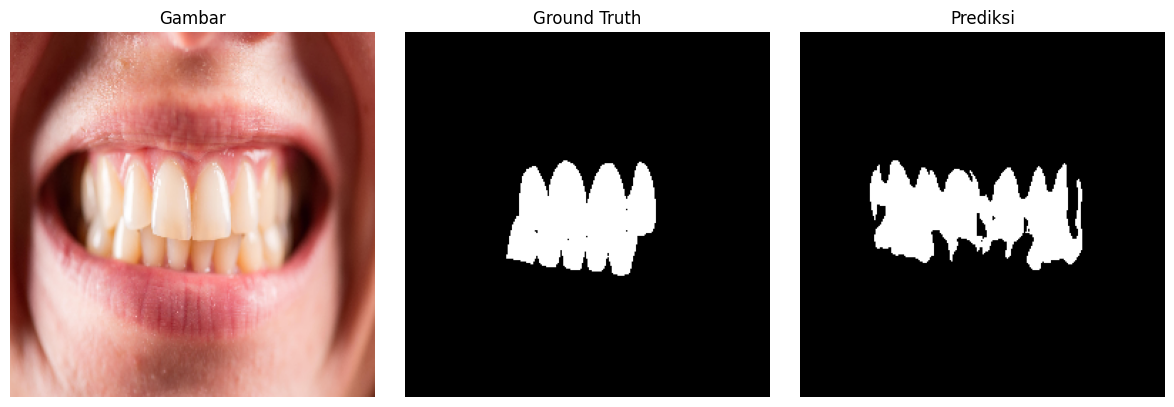

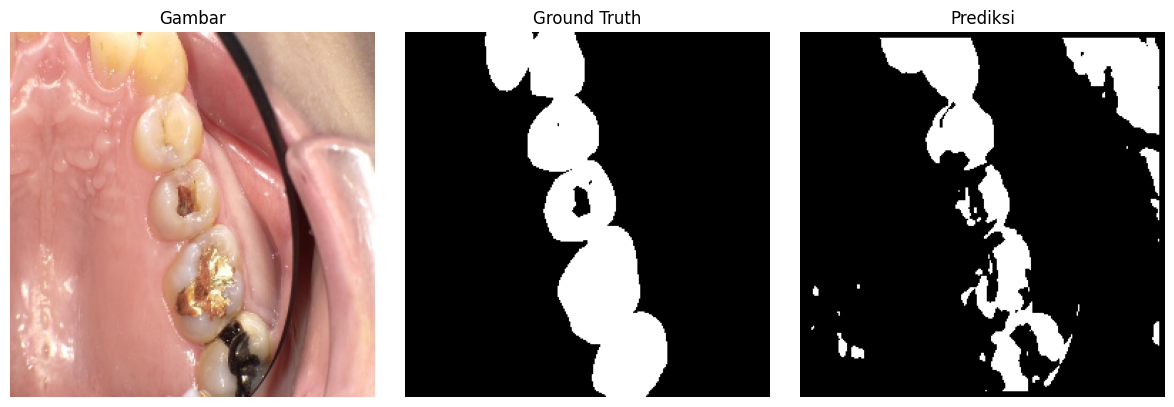

In [50]:
def calculate_dice_numpy(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + 1e-6) / (np.sum(y_true) + np.sum(y_pred) + 1e-6)

X_val_batch, Y_val_batch = next(iter(val_dataset))
Y_pred_batch = model.predict(X_val_batch)
Y_pred_bin = (Y_pred_batch > 0.5).astype(np.uint8)

# Tampilkan 4 sample
for i in range(min(4, len(X_val_batch))):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(X_val_batch[i])
    plt.title("Gambar")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    # Remove .numpy() as Y_val_batch is already a numpy array
    plt.imshow(Y_val_batch[i].squeeze(), cmap='gray')
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(Y_pred_bin[i].squeeze(), cmap='gray')
    plt.title("Prediksi")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

In [51]:
def calculate_dice_numpy(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + 1e-6) / (np.sum(y_true) + np.sum(y_pred) + 1e-6)

dice_scores = [
    calculate_dice_numpy(Y_val_batch[i].squeeze(), Y_pred_bin[i]) # Remove .numpy() and use .squeeze() to remove unnecessary dimensions if any.
    for i in range(len(Y_val_batch))
]

print(f"Rata-rata Dice Coefficient (Manual): {np.mean(dice_scores):.4f}")

Rata-rata Dice Coefficient (Manual): 0.7778


## Deployment Model

In [52]:
# Simpan model ke file HDF5
model.save("unet_dental_segmentation.h5")
